reference video: https://www.youtube.com/watch?v=jztwpsIzEGc&t=981s

Imports

In [187]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np
import keras
from keras import ops
import os
import random
import numpy as np
import shutil
import tensorflow as tf
from collections import Counter
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

We now try to take the data folder, and split it into multiple data folders, each of these folders containing one individual picture classification

BEFORE RUNNING THIS STEP: please have image folder in parent directory and data_classes folder in experimental


In [ ]:
import os
import shutil


def display_batch(images, labels, num_images=64):
    plt.figure(figsize=(12, 12))
    grid_size = int(num_images**0.5)  # Create an approximate square grid for display
    
    for i in range(num_images):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[i])  # Convert to uint8 if necessary for display
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()



def organise_images_by_class(image_directory, parent_directory):
    """
    Organizes images into subdirectories based on their class names derived from the filenames.

    Parameters:
    - image_directory (str): Path to the directory containing the images.
    - parent_directory (str): Path to the parent directory where class subdirectories will be created.
    """
    classes = set()
    for image in os.listdir(image_directory):
        classes.add(image[:2])

    newlist = []
    for classname in list(classes):
        newstring = ""
        for char in classname:
            if char.isnumeric():
                newstring += char
        newlist.append(int(newstring))

    for num in newlist:
        dir_path = os.path.join(parent_directory, str(num))
        os.makedirs(dir_path, exist_ok=True)
        print(f"Directory {dir_path} created.")

    for imagefilename in os.listdir(image_directory):
        newstring = ""
        for char in imagefilename[:2]:
            if char.isnumeric():
                newstring += char
        targetdirectory = os.path.join(parent_directory, newstring)
        newimagepath = os.path.join(image_directory, imagefilename)
        shutil.move(newimagepath, targetdirectory)
        print(f"Image {imagefilename} moved to {targetdirectory}.")

"""
image_file_path="../images"
data_classes="../data_classes"
#organise_images_by_classes()
"""


In [181]:
import os
import matplotlib.pyplot as plt

def plot_number_of_images(file_path):
    # Define the path to your dataset directory
    dataset_directory = file_path

    # Initialize a list to hold counts for each class
    class_counts = []

    for i in range(23):
        class_folder = os.path.join(dataset_directory, str(i))
        if os.path.isdir(class_folder):
            image_count = len([f for f in os.listdir(class_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
            class_counts.append(image_count)
        else:
            class_counts.append(0)

    # Create class labels
    class_labels = [str(i) for i in range(23)]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_counts, color='skyblue')
    plt.xlabel('Class Labels (0 to 22)')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Class')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.show()


def even_out_class_size(dataset_directory, balanced_directory):
    os.makedirs(balanced_directory, exist_ok=True)

    class_counts = []
    class_folders = []

    for i in range(23):
        class_folder = os.path.join(dataset_directory, str(i))
        if os.path.isdir(class_folder):
            image_files = [f for f in os.listdir(class_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
            class_counts.append(len(image_files))
            class_folders.append(class_folder)

    median_count = int(np.median(class_counts))
    target_count = median_count
    print(f"Median image count: {median_count}")

    final_class_counts = []
    for class_folder in class_folders:
        class_images = [f for f in os.listdir(class_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if len(class_images) > target_count:
            selected_images = random.sample(class_images, target_count)
            final_class_counts.append(target_count)
        else:
            selected_images = class_images
            final_class_counts.append(len(selected_images))

        target_class_folder = os.path.join(balanced_directory, os.path.basename(class_folder))
        os.makedirs(target_class_folder, exist_ok=True)
        for image in selected_images:
            shutil.copy(os.path.join(class_folder, image), os.path.join(target_class_folder, image))


def top_up_images(balanced_directory):
    end_image_count=400
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.2),                    
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.GaussianNoise(0.2)
    ])

    for class_folder in os.listdir(balanced_directory):
        target_class_folder = os.path.join(balanced_directory, class_folder)
        current_count = len(os.listdir(target_class_folder))
        
        while current_count < end_image_count:
            for image_name in os.listdir(target_class_folder):
                image_path = os.path.join(target_class_folder, image_name)
                image = tf.keras.utils.load_img(image_path)
                image = tf.keras.utils.img_to_array(image)
                
                augmented_image = data_augmentation(tf.expand_dims(image, axis=0))
                augmented_image = tf.squeeze(augmented_image).numpy()
                augmented_image_path = os.path.join(target_class_folder, f"aug_{current_count}_{image_name}")
                tf.keras.utils.save_img(augmented_image_path, augmented_image)
                current_count += 1
                
                if current_count >= end_image_count:
                    break


def plot_loss_and_accuracy(hist):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Loss
    axes[0].plot(hist.history['loss'], color='teal', label='Loss')
    axes[0].plot(hist.history['val_loss'], color='orange', label='Val Loss')
    axes[0].set_title('Loss', fontsize=16)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss Value')
    axes[0].legend(loc="upper left")
    
    # Plot Accuracy
    axes[1].plot(hist.history['accuracy'], color='teal', label='Accuracy')
    axes[1].plot(hist.history['val_accuracy'], color='orange', label='Val Accuracy')
    axes[1].set_title('Accuracy', fontsize=16)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy Value')
    axes[1].legend(loc="upper left")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

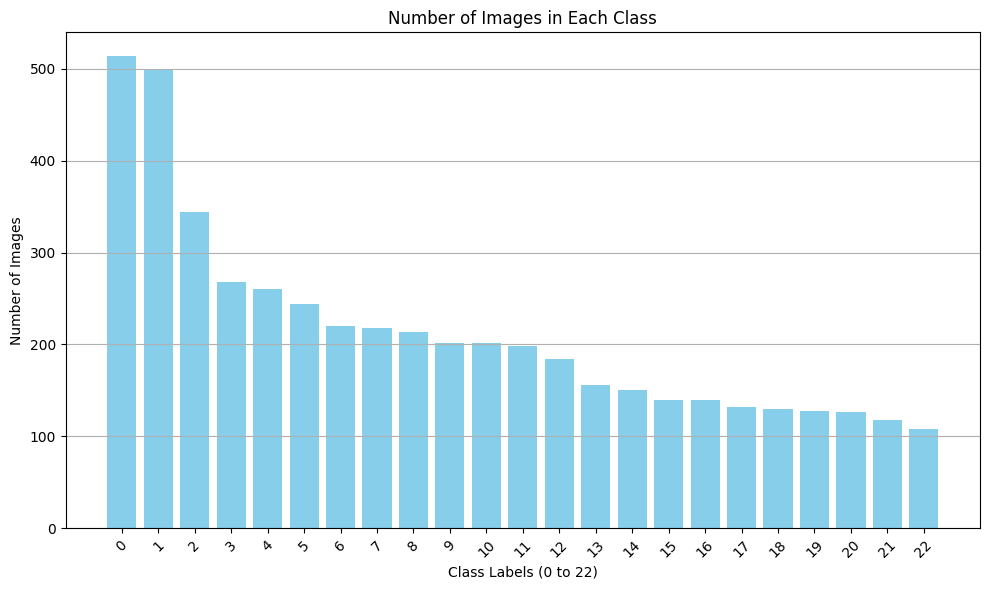

In [66]:
plot_number_of_images(file_path="../experimental/data_classes")

Median image count: 198


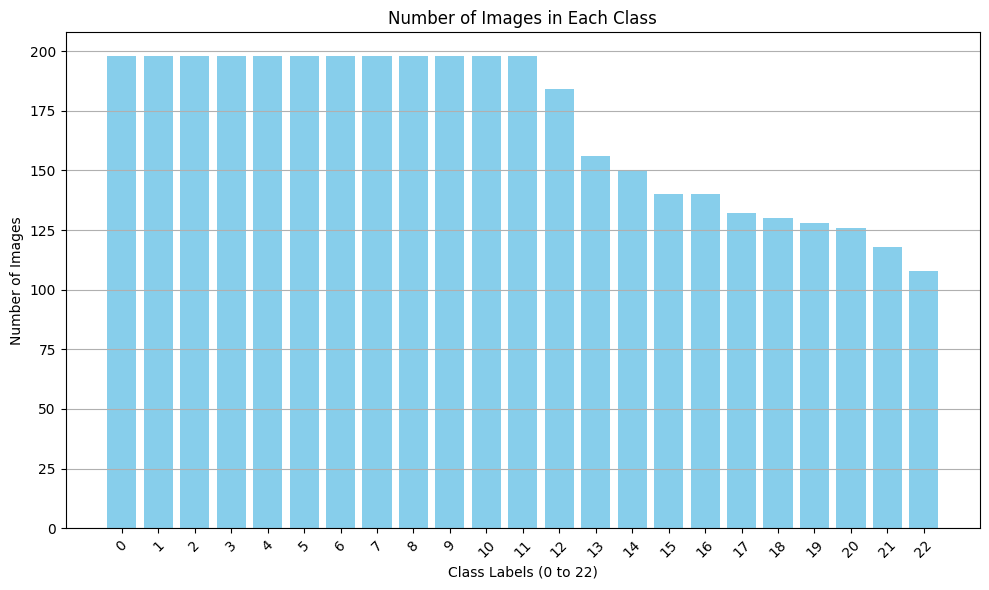

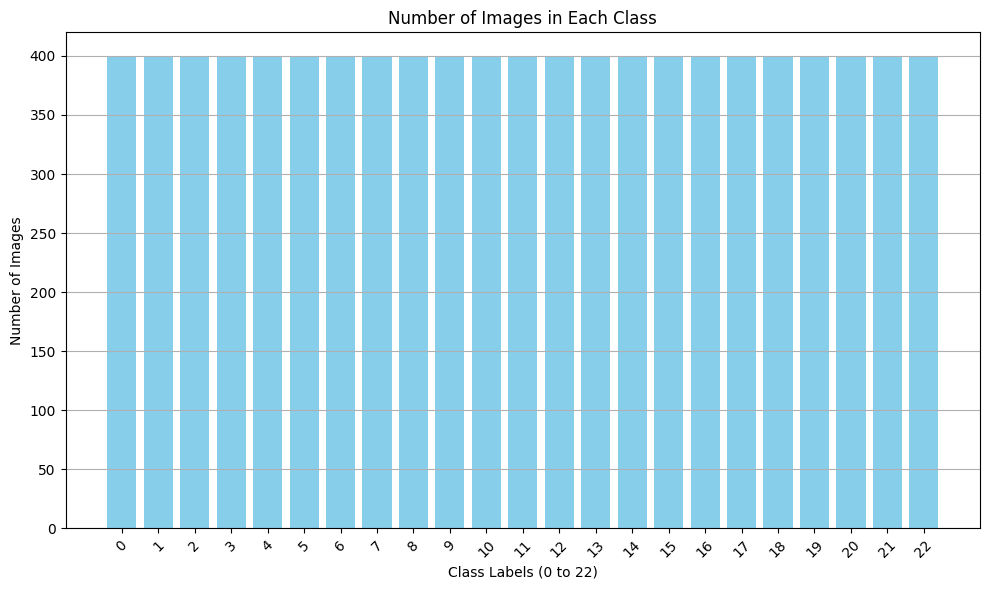

In [67]:
dataset_directory = "../experimental/data_classes"
balanced_directory = "../experimental/balanced_data_classes"

even_out_class_size(dataset_directory, balanced_directory)
plot_number_of_images(file_path="../experimental/balanced_data_classes")

top_up_images(balanced_directory)
plot_number_of_images(file_path="../experimental/balanced_data_classes")

image resizing testing, using this technique we can successfully resize the image to a standard size of 128,128,3, without sacrificing any major features of the photo 

(402, 491, 3)
(128, 128, 3)


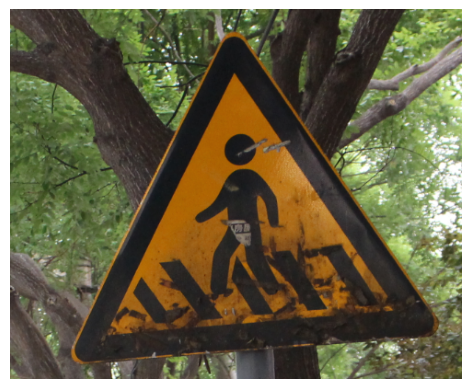

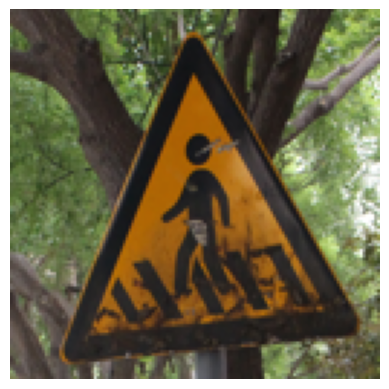

In [68]:
from PIL import Image
import matplotlib.pyplot as plt

'''
img = Image.open('../experimental/data_classes/10/10_577.png') 
new_img = img.resize((128, 128))
new_img.save("../experimental/resized_image/image.png")
'''

old_img_array=cv2.imread('../experimental/data_classes/10/10_577.png')
new_img_array=cv2.imread("../experimental/resized_image/image.png")
print(old_img_array.shape)
print(new_img_array.shape)


plt.imshow(cv2.cvtColor(old_img_array, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

plt.imshow(cv2.cvtColor(new_img_array, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

Now we try to construct an image dataset from our image_directory, which is already nicely split up for us. There is a keras library for this:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

Found 4896 files belonging to 23 classes.


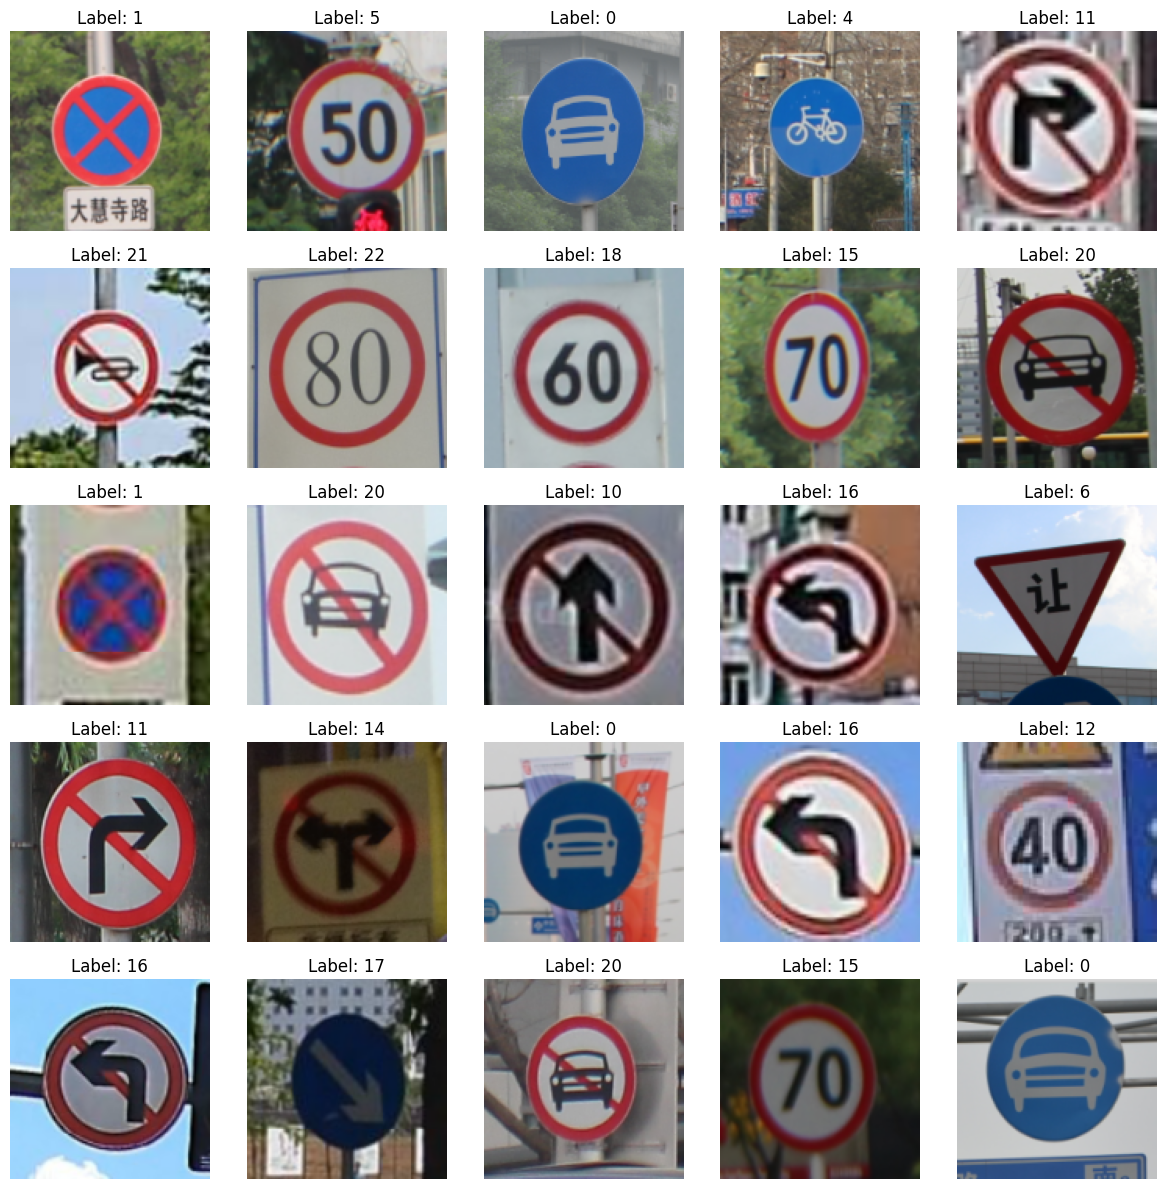

In [171]:
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt

data=tf.keras.utils.image_dataset_from_directory("../experimental/data_classes",
                                                image_size=(128, 128),
                                                batch_size=256,
                                                seed=42, 
                                                label_mode="int"
                                                )
data=data.map(lambda x, y: (x/255, y))
data_iterator= data.as_numpy_iterator()
batch=data_iterator.next()
display_batch(batch[0], batch[1], num_images=25)

Found 9200 files belonging to 23 classes.


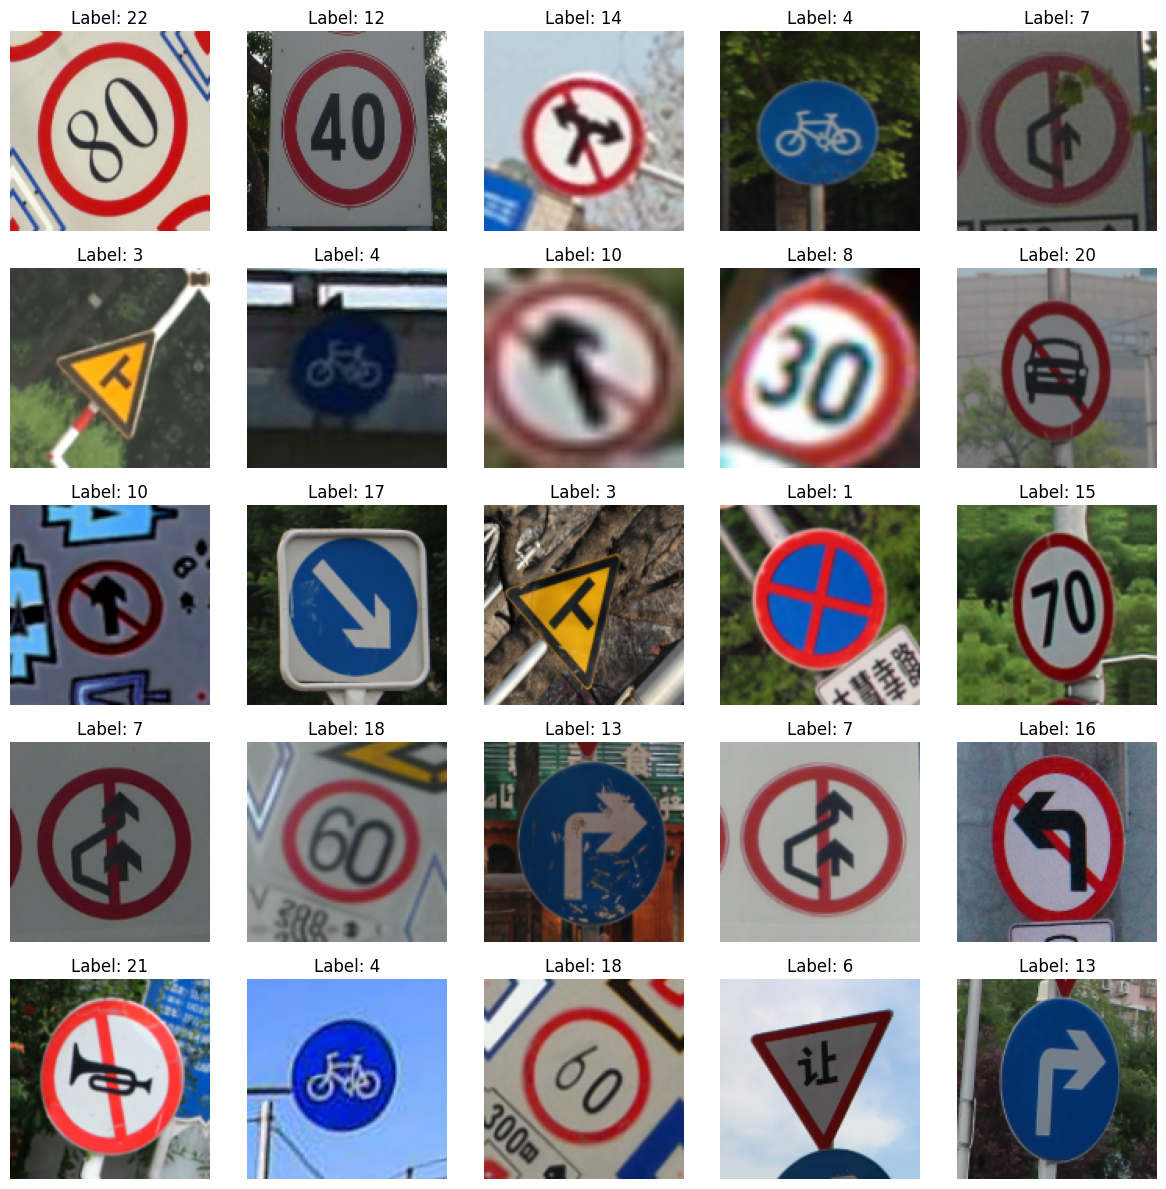

In [175]:
augmented_data = tf.keras.utils.image_dataset_from_directory(
                    "../experimental/balanced_data_classes",
                    image_size=(128, 128),
                    batch_size=256,
                    seed=42, 
                    label_mode="int",
                    shuffle=True
                )
                
augmented_data=augmented_data.map(lambda x, y: (x/255, y))
augmented_data_iterator= augmented_data.as_numpy_iterator()
augmented_batch=augmented_data_iterator.next()
display_batch(augmented_batch[0], augmented_batch[1], num_images=25)

as can be seen, values should now be represented in zero to one ranges

Batch 1 counts: {7: 3, 22: 5, 8: 5, 3: 4, 10: 1, 19: 4, 21: 6, 0: 5, 1: 7, 15: 1, 16: 4, 6: 1, 9: 3, 17: 1, 20: 4, 14: 1, 12: 2, 18: 3, 11: 2, 2: 2}
Batch 2 counts: {0: 7, 11: 2, 19: 5, 22: 5, 12: 1, 15: 4, 10: 5, 1: 9, 16: 4, 3: 4, 4: 3, 21: 2, 9: 3, 2: 1, 17: 3, 6: 2, 18: 2, 8: 1, 20: 1}
Batch 3 counts: {4: 4, 18: 4, 8: 1, 20: 1, 1: 8, 21: 3, 17: 2, 14: 4, 10: 4, 0: 7, 19: 4, 15: 2, 16: 4, 5: 2, 2: 3, 12: 3, 7: 2, 22: 2, 13: 1, 3: 2, 6: 1}
Batch 4 counts: {2: 1, 1: 10, 9: 4, 13: 1, 20: 5, 18: 4, 0: 8, 22: 4, 7: 2, 4: 2, 14: 3, 19: 4, 16: 4, 8: 2, 21: 1, 15: 2, 5: 2, 17: 1, 12: 2, 3: 2}
Batch 5 counts: {3: 4, 15: 3, 1: 10, 21: 5, 20: 1, 16: 4, 12: 6, 8: 2, 2: 3, 18: 7, 17: 1, 14: 1, 22: 3, 0: 5, 4: 2, 5: 3, 7: 1, 9: 1, 19: 1, 13: 1}
Batch 6 counts: {12: 4, 16: 6, 1: 5, 17: 2, 19: 3, 22: 3, 0: 6, 20: 4, 10: 4, 21: 1, 4: 5, 2: 2, 9: 2, 15: 2, 18: 5, 7: 2, 11: 2, 8: 1, 3: 2, 6: 2, 5: 1}
Batch 7 counts: {18: 5, 9: 2, 5: 1, 4: 4, 10: 5, 0: 5, 21: 2, 17: 5, 13: 1, 1: 10, 11: 2, 12: 7, 6: 2,

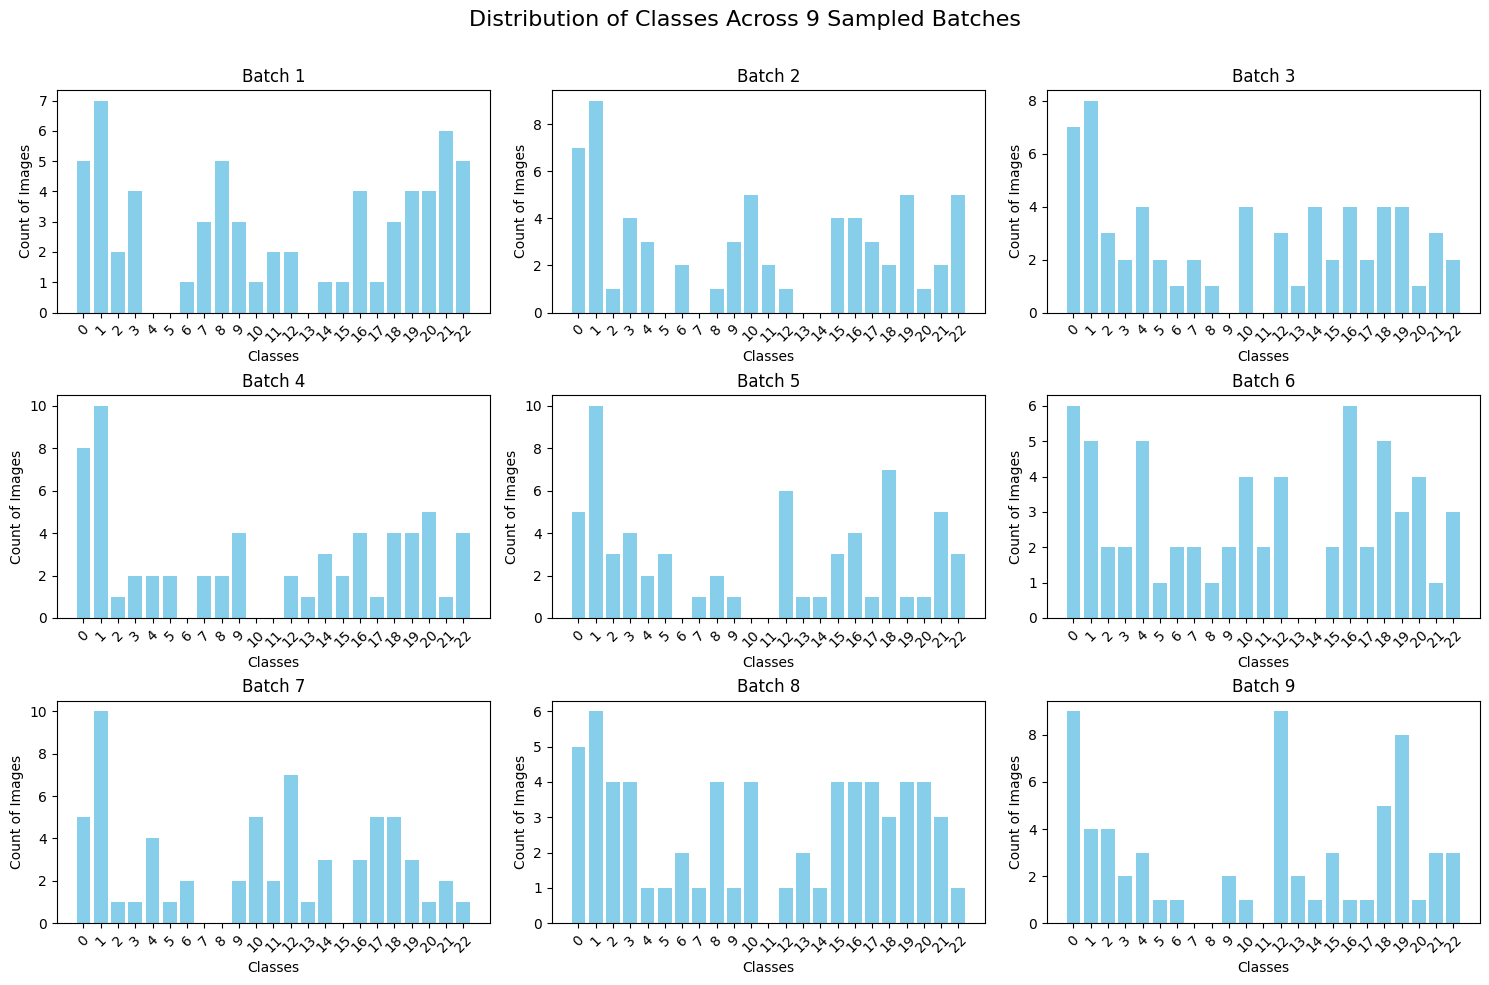

Batch 1 counts: {19: 13, 14: 11, 4: 14, 6: 9, 22: 13, 9: 8, 21: 18, 1: 15, 20: 9, 7: 13, 18: 9, 0: 14, 5: 7, 13: 15, 3: 8, 10: 15, 15: 7, 8: 6, 11: 12, 2: 14, 16: 7, 12: 7, 17: 12}
Batch 2 counts: {0: 9, 11: 19, 13: 14, 22: 16, 16: 14, 12: 11, 9: 9, 10: 13, 19: 13, 20: 13, 4: 10, 21: 18, 6: 10, 7: 10, 1: 9, 14: 6, 8: 10, 18: 6, 15: 9, 2: 14, 3: 11, 5: 7, 17: 5}
Batch 3 counts: {8: 10, 11: 15, 18: 8, 14: 13, 4: 16, 3: 12, 16: 15, 10: 11, 22: 12, 2: 13, 19: 8, 12: 9, 6: 10, 15: 11, 0: 14, 21: 11, 5: 8, 13: 7, 7: 9, 9: 11, 17: 10, 1: 13, 20: 10}
Batch 4 counts: {3: 17, 13: 11, 14: 10, 20: 20, 2: 7, 22: 12, 5: 14, 17: 10, 7: 15, 9: 12, 16: 7, 12: 11, 1: 12, 10: 15, 15: 9, 18: 10, 21: 9, 4: 10, 6: 8, 8: 10, 19: 9, 0: 8, 11: 10}
Batch 5 counts: {21: 9, 2: 12, 10: 17, 18: 8, 14: 14, 3: 5, 16: 13, 4: 14, 0: 17, 8: 12, 7: 13, 15: 8, 11: 9, 17: 8, 5: 6, 12: 13, 22: 10, 6: 16, 20: 11, 19: 12, 1: 17, 9: 8, 13: 4}
Batch 6 counts: {19: 10, 13: 14, 6: 15, 16: 13, 20: 13, 18: 14, 3: 17, 12: 10, 10: 12

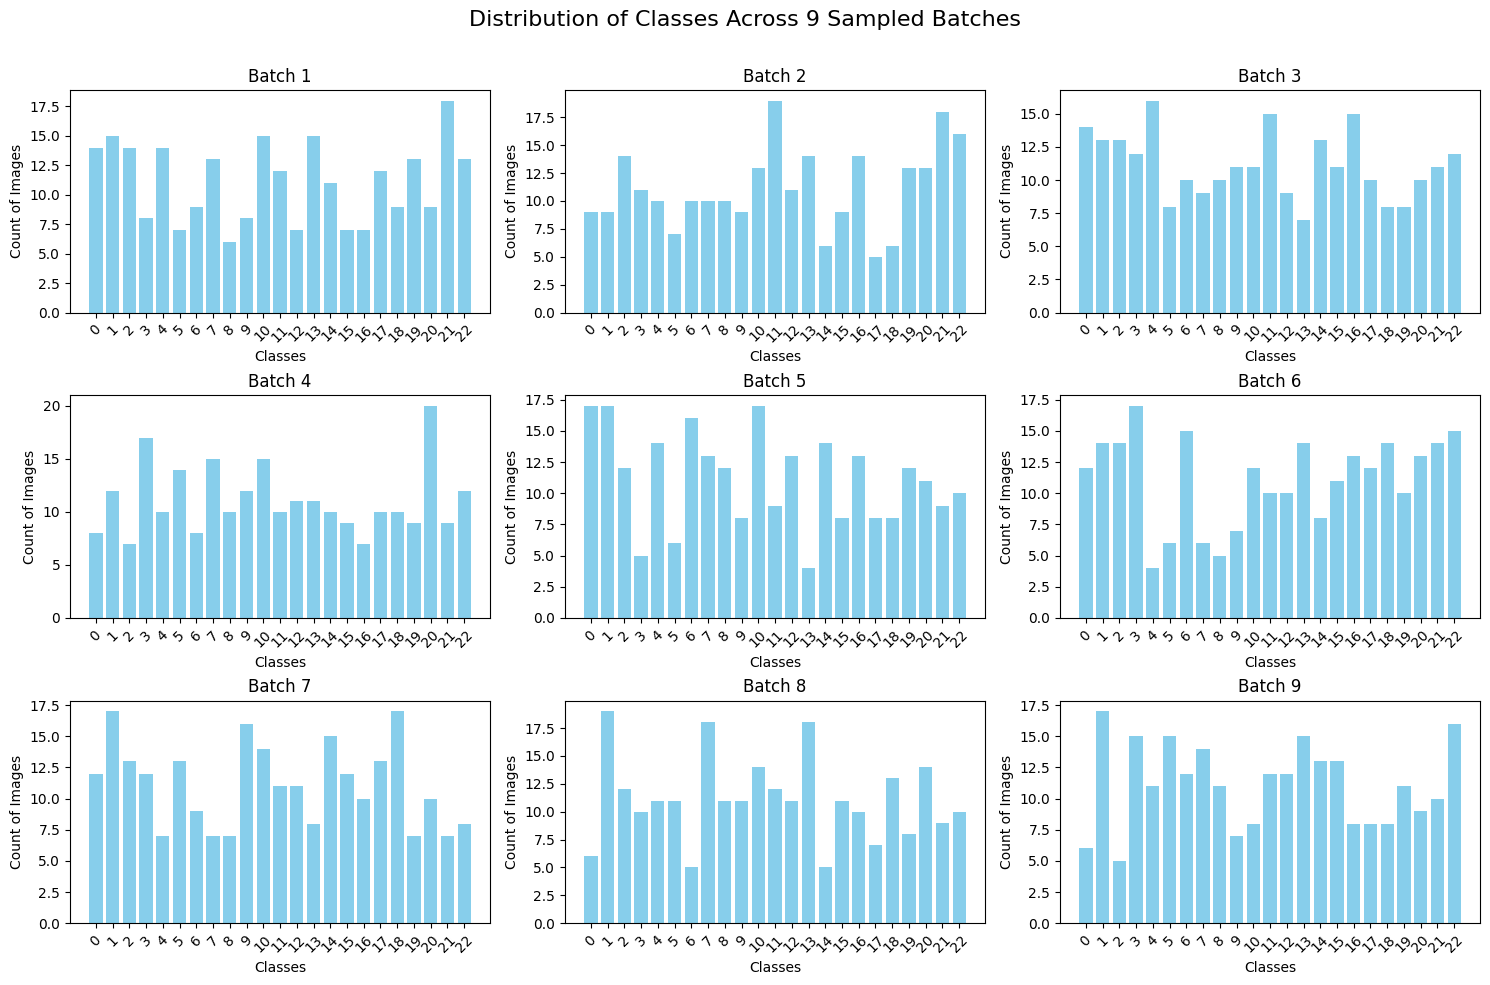

In [176]:
def count_classes_in_sampled_batches(dataset, num_batches=9, plot=True):
    """
    Count the occurrences of each class in a sampled number of batches of the dataset.

    Parameters:
    - dataset: A TensorFlow dataset object containing images and labels.
    - num_batches: Number of batches to sample (default is 9).
    - plot: A boolean indicating whether to plot the counts (default is True).

    Returns:
    - batch_counts: A list of Counter objects with counts for each sampled batch.
    """
    batch_counts = []
    for i, (images, labels) in enumerate(dataset):
        if i >= num_batches:  
            break
        label_counts = Counter(labels.numpy())
        batch_counts.append(label_counts)

    for i, counts in enumerate(batch_counts):
        print(f"Batch {i + 1} counts: {dict(counts)}")

    if plot:
        all_classes = sorted(set().union(*[counts.keys() for counts in batch_counts]))
        
        fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
        axs = axs.flatten()

        for batch_index, counts in enumerate(batch_counts):
            # Prepare data for each subplot
            counts_values = [counts.get(cls, 0) for cls in all_classes]
            
            # Create a bar plot for the current batch
            axs[batch_index].bar(all_classes, counts_values, color='skyblue')
            axs[batch_index].set_title(f'Batch {batch_index + 1}')
            axs[batch_index].set_xlabel('Classes')
            axs[batch_index].set_ylabel('Count of Images')
            axs[batch_index].set_xticks(all_classes)  # Set x-ticks to class labels
            axs[batch_index].set_xticklabels(all_classes, rotation=45)

        # Adjust layout
        plt.tight_layout()
        plt.suptitle(f'Distribution of Classes Across {num_batches} Sampled Batches', fontsize=16)
        plt.subplots_adjust(top=0.9)  # Adjust top space to fit the suptitle

        plt.show()
    
    return batch_counts

    

batch_counts = count_classes_in_sampled_batches(original_data)
augmented_batch_count = count_classes_in_sampled_batches(augmented_data)





train set= 70%
validation set= 20%
test set= 10%


In [183]:
numBatch=len(data)
trainsize=int(0.7*numBatch)
valsize=int(0.2*numBatch)+1
testsize=int(0.1*numBatch)+1


train=data.take(trainsize)
val=data.skip(trainsize).take(valsize)
test=data.skip(trainsize+valsize).take(testsize)


In [185]:
numBatch_augmented=len(augmented_data)
augmented_trainsize=int(0.7*numBatch_augmented)
augmented_valsize=int(0.2*numBatch_augmented)+1
augmented_testsize=int(0.1*numBatch_augmented)+1


augmented_train=augmented_data.take(augmented_trainsize)
augmented_val=augmented_data.skip(augmented_trainsize).take(augmented_valsize)
augmented_test=augmented_data.skip(augmented_trainsize+augmented_valsize).take(augmented_testsize)

print(len(augmented_train))
print(len(augmented_val))
print(len(augmented_test))

14
5
1
25
8
3


now we distribute the train, val and test set

In [193]:
def create_callbacks(log_dir):
    """
    Create a list of Keras callbacks.

    Parameters:
    - dog_dir (str): Directory for TensorBoard logs.

    Returns:
    - list: A list of Keras callback instances.
    """
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
    return callbacks

In [195]:
vanilla_model=Sequential()

vanilla_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(128,128,3)))
vanilla_model.add(MaxPooling2D())
vanilla_model.add(Conv2D(32, (3,3), 1, activation='relu'))
vanilla_model.add(MaxPooling2D())
vanilla_model.add(Conv2D(16, (3,3), 1, activation='relu'))
vanilla_model.add(MaxPooling2D())
vanilla_model.add(Flatten())
vanilla_model.add(Dense(256, activation='relu'))
vanilla_model.add(Dense(23, activation='softmax'))

vanilla_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

vanilla_model.summary()

vanilla_logdir='logs_vanilla'

vanilla_hist = vanilla_model.fit(train, batch_size=64, epochs=20, validation_data=val, callbacks=create_callbacks(vanilla_logdir), verbose=1)
vanilla_model.save("../experimental/models/vanilla_model.keras")

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 818,695 (3.12 MB)

 Trainable params: 818,695 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1448 - loss: 2.9485 - val_accuracy: 0.3664 - val_loss: 2.2199 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4447 - loss: 1.9657 - val_accuracy: 0.6672 - val_loss: 1.1716 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7033 - loss: 1.0140 - val_accuracy: 0.8430 - val_loss: 0.5749 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8287 - loss: 0.5878 - val_accuracy: 0.8867 - val_loss: 0.3931 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9212 - loss: 0.2934 - val_accuracy: 0.9555 - val_loss: 0.1921 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9560 - loss: 0.1711 - val_accuracy: 0.9711 - val_loss: 0.1203 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9782 - loss: 0.1019 - val_accuracy: 

as we can see the output is not one hot encoded, so we use sparese 

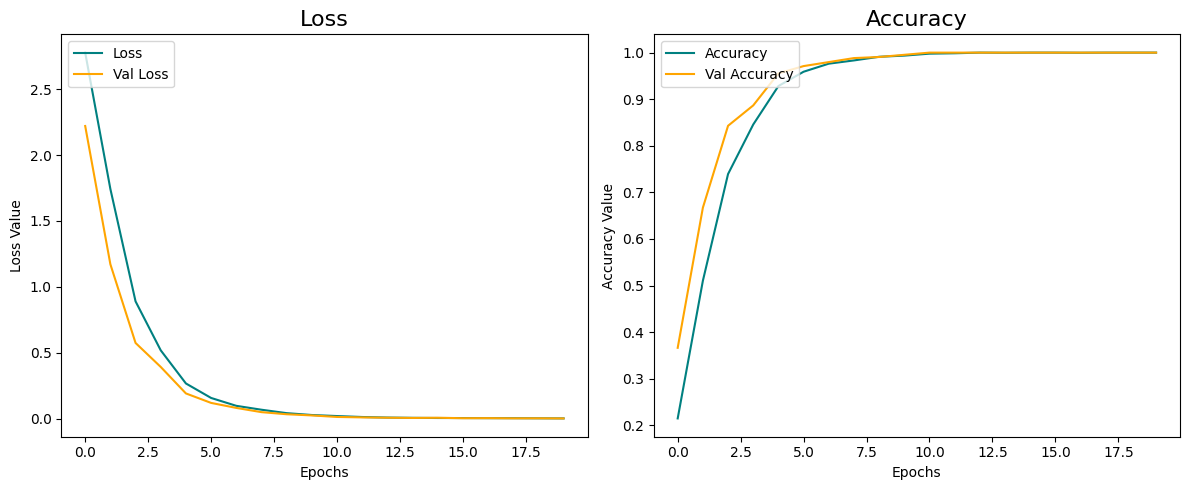

In [196]:
plot_loss_and_accuracy(vanilla_hist)

Testing and evaluating model, we can see that for first implementation, it already does pretty well

In [199]:
def get_misclassifications(model, dataset, class_names):
    all_predictions = []
    all_labels = []
    
    # Get predictions
    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        all_predictions.extend(predictions)
        all_labels.extend(labels.numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Get predicted classes
    pred_classes = np.argmax(all_predictions, axis=1)
    
    # Since labels are not one-hot encoded, use them directly
    true_classes = all_labels.astype(int)  # Assuming labels are integers
    
    # Find misclassified examples
    misclassified_idx = np.where(pred_classes != true_classes)[0]
    
    # Create list of misclassifications
    misclassifications = []
    for idx in misclassified_idx:
        misclassifications.append([
            idx,  # index
            class_names[true_classes[idx]],  # true class
            class_names[pred_classes[idx]],  # predicted class
            f"{np.max(all_predictions[idx]) * 100:.2f}%"  # confidence
        ])
    
    # Print as a list of lists
    print("\nMisclassified Images:")
    print(misclassifications)
    
    return misclassifications

In [200]:
class_names = [str(i) for i in range(23)]
misclassified_val = get_misclassifications(vanilla_model, val, class_names)
misclassified_test = get_misclassifications(vanilla_model, test, class_names)


Misclassified Images:
[]

Misclassified Images:
[]


In [201]:
vanilla_pre=Precision()
vanilla_rec=Recall()
vanilla_acc=Accuracy()

reconstructed_vanilla_model=keras.models.load_model("../experimental/models/vanilla_model.keras") 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


2024-10-31 15:30:04.155088: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Impressive results with testing data(completely unseen with model), with a 99.7% precision, 97.9% accuracy and a perfect recall, but is this model really robust?

In [203]:
print(vanilla_acc.result())

tf.Tensor(1.0, shape=(), dtype=float32)


In [204]:
def evaluate_model_for_specific_classes(model, test_dataset, class_1=6, class_2=10):
    """
    Evaluates the model on the test dataset and calculates false negative rates for the specified classes.

    Parameters:
        model: The trained model to evaluate.
        test_dataset: The dataset used for testing, yielding images and corresponding labels.
        class_1: The first class of interest.
        class_2: The second class of interest.

    Returns:
        dict: A dictionary with false negative rates for each specified class, test loss, and test accuracy.
    """
    y_true = []
    y_pred = []
    
    # Generate predictions and true labels
    for images, labels in test_dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels
        y_true.extend(labels.numpy())  # True labels, assumed to be class indices
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    false_negative_rates = {}
    
    # Calculate false negatives for the specified classes
    for class_of_interest in [class_1, class_2]:
        false_negatives = np.sum((y_true == class_of_interest) & (y_pred != class_of_interest))
        total_positives = np.sum(y_true == class_of_interest)
        
        # Calculate false negative rate
        false_negative_rate = false_negatives / total_positives if total_positives > 0 else 0
        false_negative_rates[class_of_interest] = false_negative_rate
    
    # Evaluate the model on the test dataset
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test accuracy: {test_acc:.4f}")

    return false_negative_rates, test_loss, test_acc

In [206]:
print(evaluate_model_for_specific_classes(reconstructed_vanilla_model, test, class_1=6, class_2=10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0060
Test accuracy: 1.0000
({6: 0, 10: 0}, 0.006002600304782391, 1.0)


Possible room for improvement?

- Bigger dataset, take training data and distort some, rotate some images, etc: helps the CNN recognise key features of the signs


In [207]:
print(evaluate_model_for_specific_classes(reconstructed_vanilla_model, augmented_test, class_1=6, class_2=10))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.6780 - loss: 3.2606
Test accuracy: 0.6782
({6: 0.4166666666666667, 10: 0.47058823529411764}, 3.285653591156006, 0.6781914830207825)


Now we see that the model is actually not too robust to rotations, cropping and the addition of noise. 

In [209]:
augmented_model=Sequential()

augmented_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(128,128,3)))
augmented_model.add(MaxPooling2D())
augmented_model.add(Conv2D(32, (3,3), 1, activation='relu'))
augmented_model.add(MaxPooling2D())
augmented_model.add(Conv2D(16, (3,3), 1, activation='relu'))
augmented_model.add(MaxPooling2D())
augmented_model.add(Flatten())
augmented_model.add(Dense(256, activation='relu'))
augmented_model.add(Dense(23, activation='softmax'))


augmented_model.summary()

augmented_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

logdir_augmented='logs_augmented'

hist_augmented = augmented_model.fit(augmented_train, batch_size=16, epochs=50, validation_data=augmented_val, callbacks=create_callbacks(logdir_augmented), verbose=1)

augmented_model.save("../experimental/models/augmented_model.keras")

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 818,695 (3.12 MB)

 Trainable params: 818,695 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1558 - loss: 2.8980 - val_accuracy: 0.4321 - val_loss: 1.9026 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4966 - loss: 1.6635 - val_accuracy: 0.6572 - val_loss: 1.1830 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7040 - loss: 1.0027 - val_accuracy: 0.7441 - val_loss: 0.8484 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7965 - loss: 0.6665 - val_accuracy: 0.8223 - val_loss: 0.5935 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8549 - loss: 0.4672 - val_accuracy: 0.8706 - val_loss: 0.4495 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8948 - loss: 0.3348 - val_accuracy: 0.8999 - val_loss: 0.3568 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9235 - loss: 0.2535 - val_accuracy: 

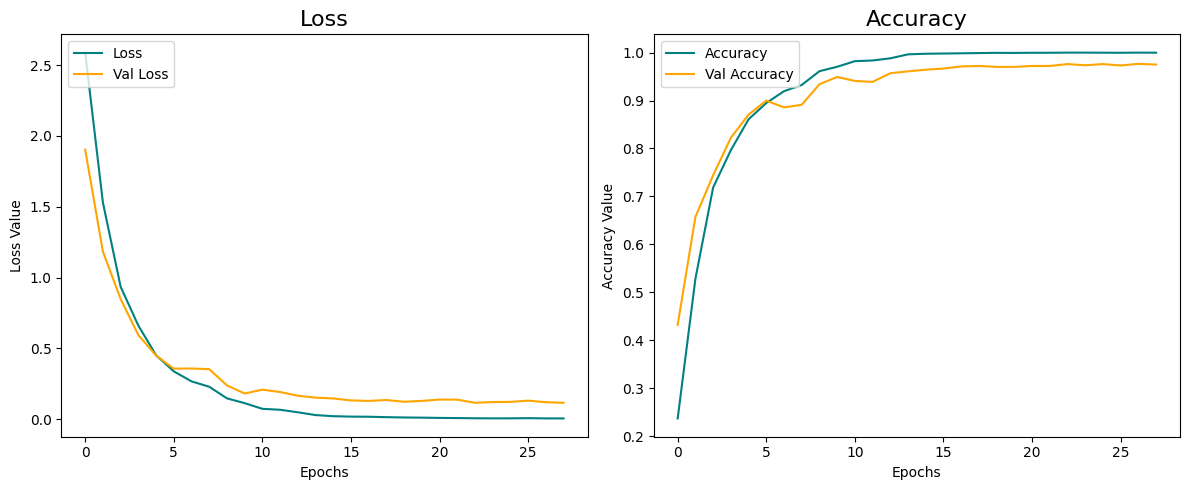

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - accuracy: 0.9796 - loss: 0.1332
Test accuracy: 0.9787
({6: 0.058823529411764705, 10: 0.0}, 0.11507730185985565, 0.978723406791687)


In [210]:
plot_loss_and_accuracy(hist_augmented)

reconstructed_augmented_model=keras.models.load_model("../experimental/models/augmented_model.keras") 
print(evaluate_model_for_specific_classes(reconstructed_augmented_model, augmented_test, class_1=6, class_2=10))



In [212]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


dnn_model = Sequential()
imported_model= tf.keras.applications.ResNet50(include_top=False,input_shape=(128,128,3),pooling='avg',classes=23,weights='imagenet')
for layer in imported_model.layers:
    layer.trainable=False

dnn_model.add(imported_model)
dnn_model.add(Flatten())
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dense(23, activation='softmax'))

dnn_model.summary()

dnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

dnn_logdir="logs_dnn"

dnn_model_history = dnn_model.fit(augmented_train, batch_size=16, epochs=50, validation_data=augmented_val, callbacks=create_callbacks(dnn_logdir), verbose=1)

dnn_model.save("../experimental/models/dnn_model.keras") #save completed model after training



Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 23)             │        11,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,648,599 (94.03 MB)

 Trainable params: 1,060,887 (4.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 223s 9s/step - accuracy: 0.0672 - loss: 3.1748 - val_accuracy: 0.1519 - val_loss: 3.0063 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 184s 7s/step - accuracy: 0.1416 - loss: 2.9664 - val_accuracy: 0.1411 - val_loss: 2.9011 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 183s 7s/step - accuracy: 0.1664 - loss: 2.8492 - val_accuracy: 0.1870 - val_loss: 2.8217 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 184s 7s/step - accuracy: 0.2042 - loss: 2.7716 - val_accuracy: 0.2192 - val_loss: 2.7167 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 181s 7s/step - accuracy: 0.2230 - loss: 2.6899 - val_accuracy: 0.2539 - val_loss: 2.6569 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 192s 8s/step - accuracy: 0.2402 - loss: 2.6189 - val_accuracy: 0.2632 - val_loss: 2.5971 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 185s 7s/step - accuracy: 0.2909 - loss: 2.5401 - val_acc

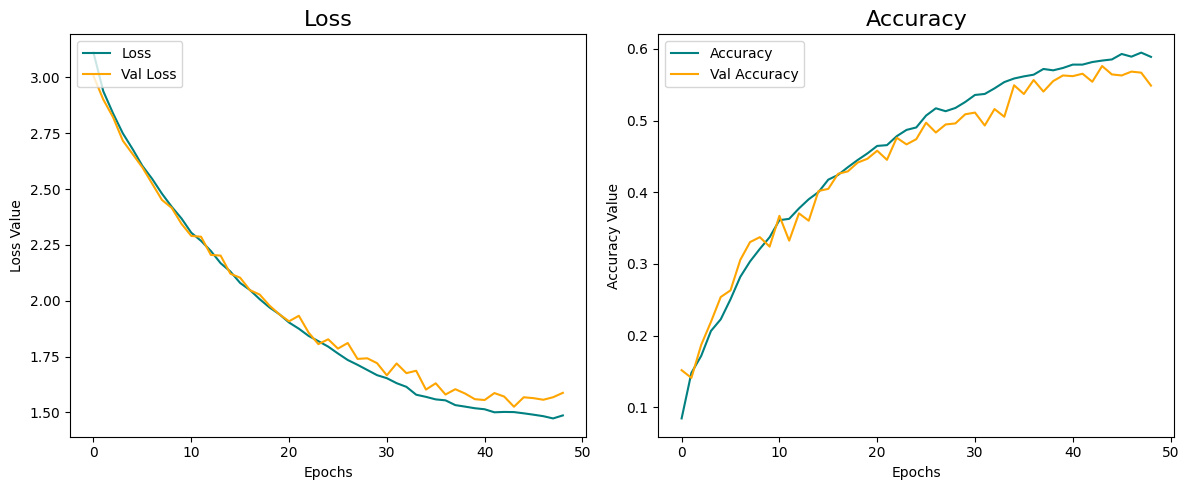

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 836ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 840ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 954ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step - accuracy: 0.5570 - loss: 1.5942
Test accuracy: 0.5505
({6: 0.2647058823529412, 10: 0.2857142857142857}, 1.5934386253356934, 0.5505319237709045)


In [214]:
plot_loss_and_accuracy(dnn_model_history)
reconstructed_dnn_augmented_model=keras.models.load_model("../experimental/models/dnn_model.keras") 
print(evaluate_model_for_specific_classes(reconstructed_dnn_augmented_model, augmented_test, class_1=6, class_2=10))

In [194]:
imported_model_mobilenet = Sequential()

imported_model= tf.keras.applications.MobileNetV2(
    include_top=False,           
    input_shape=(128, 128, 3),    
    pooling='avg',               
    weights='imagenet'            
)

# Freeze the layers of the imported model
for layer in imported_model.layers:
    layer.trainable = False

# Add the MobileNetV2 model to our Sequential model
imported_model_mobilenet.add(imported_model)

# Add custom layers for classification
imported_model_mobilenet.add(Flatten())
imported_model_mobilenet.add(Dense(512, activation='relu'))
imported_model_mobilenet.add(Dense(23, activation='softmax'))  # Assuming 23 output classes

# Show the model summary
imported_model_mobilenet.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 23)             │        11,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,925,655 (11.16 MB)

 Trainable params: 667,671 (2.55 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [196]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam

imported_model_mobilenet.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy',      
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    TensorBoard(log_dir='./logs', histogram_freq=1)  
]

# Train the model
mobilenet_history = imported_model_mobilenet.fit(
    augmented_train,                          
    validation_data=augmented_val,          
    epochs=50,                        
    callbacks=callbacks 
)          

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 76s 663ms/step - accuracy: 0.6990 - loss: 1.1309 - val_accuracy: 0.6023 - val_loss: 1.2830 - learning_rate: 0.0010
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 76s 715ms/step - accuracy: 0.9551 - loss: 0.1813 - val_accuracy: 0.7258 - val_loss: 0.8797 - learning_rate: 0.0010
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 78s 725ms/step - accuracy: 0.9781 - loss: 0.0931 - val_accuracy: 0.7308 - val_loss: 0.8284 - learning_rate: 0.0010
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 76s 709ms/step - accuracy: 0.9840 - loss: 0.0689 - val_accuracy: 0.7550 - val_loss: 0.7478 - learning_rate: 0.0010
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 68s 636ms/step - accuracy: 0.9854 - loss: 0.0571 - val_accuracy: 0.7707 - val_loss: 0.6773 - learning_rate: 0.0010
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 71s 661ms/step - accuracy: 0.9871 - loss: 0.0471 - val_accuracy: 0.7833 - val_loss: 0.6381 - learning_rate: 0.0010
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 76s 709ms/step - accuracy: 0.9

In [197]:
imported_model_mobilenet.save("../experimental/models/mobile_net_model.keras") #save completed model after training

In [198]:
mobile_net_pre=Precision()
mobile_net_rec=Recall()
mobile_net_acc=Accuracy()

reconstructed_mobile_net=keras.models.load_model("../experimental/models/mobile_net_model.keras") 

for batch in augmented_test.as_numpy_iterator():
    x,y=batch
    predicted=reconstructed_mobile_net.predict(x)
    yhat=np.argmax(predicted, axis=1)
    dnn_acc.update_state(y, yhat)
    dnn_rec.update_state(y, yhat)
    dnn_pre.update_state(y, yhat)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


2024-10-31 01:10:29.665882: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


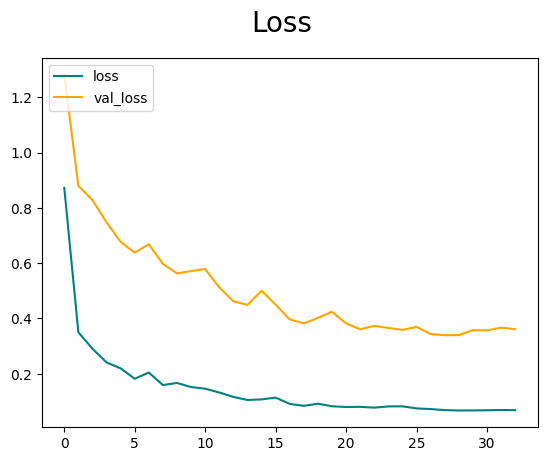

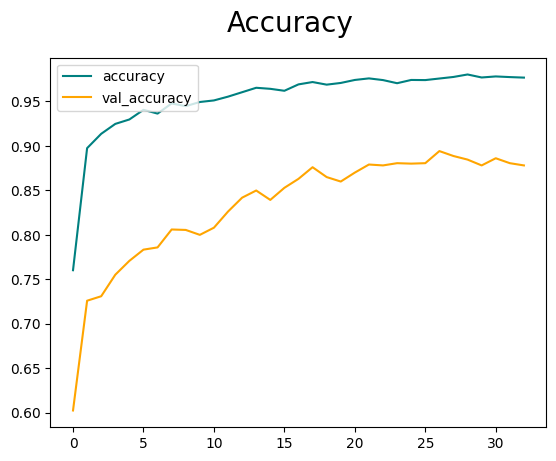

In [200]:
fig = plt.figure()
plt.plot(mobilenet_history.history['loss'], color='teal', label='loss')
plt.plot(mobilenet_history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(mobilenet_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(mobilenet_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [199]:
print(dnn_acc.result())

tf.Tensor(0.89415324, shape=(), dtype=float32)
